In [2]:
import torch
from torch import nn
from d2l import torch as d2l

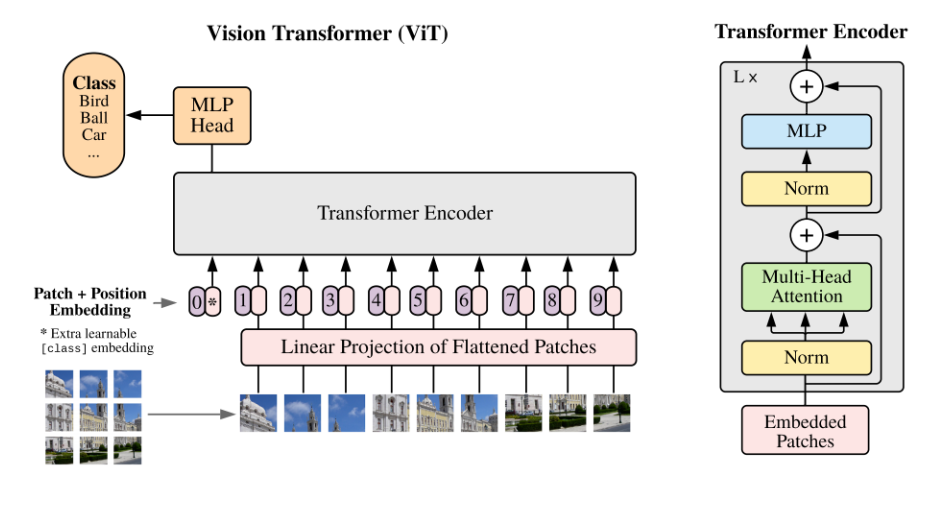

### 1. Linear Projection of Flatten Patches

(B,3,224,224) -> <br>
划分为patch, 假设每个patch为16x16=256, 则一张图14x14=196个patch <br>
(B,196,256x3=768) -> <br>
接Linear层token维度保持不变(B,196,768)

这里用卷积层来代替划分patch操作和Linear层：
(B,3,224,224) -> (B,768=256x3,14,14) -> (B,768,196) -> (B,196,768)

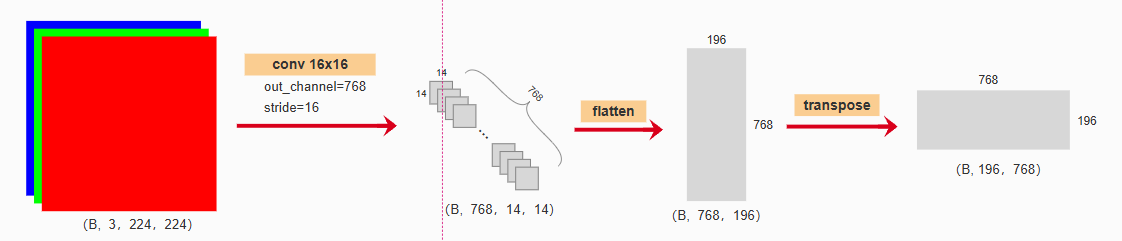

In [15]:
# Image_size 要被 patch_size 整除
class Patch_conv(nn.Module):
    def __init__(self,patch_size):
        super().__init__()
        in_dim = 3
        self.out_dim = in_dim*patch_size*patch_size # 3*16*16=768
        self.conv = nn.Conv2d(in_dim,self.out_dim,kernel_size=patch_size,stride=patch_size)
        # self.norm = nn.LayerNorm(self.out_dim)
    # X.shape=(B,C,H,W) 
    def forward(self,X):
        X = self.conv(X).flatten(2).transpose(1,2)
        # X = self.norm(X)
        return X

In [16]:
x = torch.randn((2,3,224,224))
layer = Patch_conv(16)
output = layer(x)
print(output.shape)

torch.Size([2, 196, 768])


### 2. Position Embedding and cls

In [28]:
class Position_Embedding(nn.Module):
    def __init__(self,patch_size,img_size):
        super().__init__()
        self.embeddings = 3*patch_size*patch_size
        self.tokens = (img_size//patch_size) * (img_size//patch_size) + 1
        self.cls = nn.Parameter(torch.randn(1,1,self.embeddings))
        # +1是因为cls也给了位置信息
        self.pos_emb = nn.Parameter(torch.randn(1,self.tokens,self.embeddings))
    # X.shape=(B,tokens,embeddings)
    def forward(self, X):
        # cls (1,1,embeddings) -> (B,1,embeddings)
        cls_token = self.cls.expand(X.shape[0],-1,-1)
        X = self.pos_emb + torch.concat((X,cls_token),dim=1)
        return X

In [29]:
pos_emb = Position_Embedding(patch_size=16,img_size=224)
x = pos_emb(output)
print(x.shape)

torch.Size([2, 197, 768])


### 3. Transformer Block

In [30]:
class Transformer_Block(nn.Module):
    def __init__(self,tokens,embeddings,heads,dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embeddings)
        self.Attention = d2l.MultiHeadAttention(embeddings,heads,dropout)
        self.norm2 = nn.LayerNorm(embeddings)
        self.mlp = nn.Sequential(nn.Linear(embeddings,2*embeddings),nn.ReLU(),nn.Linear(2*embeddings,embeddings))
    def forward(self,X):
        X = self.norm1(X)
        X = X + self.Attention(X,X,X,valid_lens=None)
        X = X + self.mlp(self.norm2(X))
        return X

In [31]:
transformer = Transformer_Block(x.shape[1],x.shape[2],4,dropout=0.2)
transformer.eval()
transformer_output = transformer(x)
print(transformer_output.shape)

torch.Size([2, 197, 768])


In [35]:
class Transformer(nn.Module):
    def __init__(self,num_blocks,tokens,embeddings,heads,dropout):
        super().__init__()
        self.transformer = nn.Sequential()
        for i in range(num_blocks):
            self.transformer.add_module(
                "transformer" + str(i),
                Transformer_Block(tokens,embeddings,heads,dropout)
            )
    def forward(self,X):
        for blk in self.transformer:
            X = blk(X)
        return X
        # return transformer(X) 这样写会报错????

In [36]:
transformer = Transformer(2,x.shape[1],x.shape[2],4,dropout=0.2)
transformer.eval()
transformer_output = transformer(x)
print(transformer_output.shape)

torch.Size([2, 197, 768])


In [34]:
transformer

Transformer(
  (transformer): Sequential(
    (transformer0): Transformer_Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (Attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (W_o): Linear(in_features=768, out_features=768, bias=False)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=768, out_features=1536, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1536, out_features=768, bias=True)
      )
    )
    (transformer1): Transformer_Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (Attention): MultiHeadAttention(
        (attent

In [41]:
transformer_output[:,0,:].shape

torch.Size([2, 768])

### 4. Net

In [42]:
class Vit(nn.Module):
    def __init__(self,img_size,patch_size,X_shape,num_blocks,heads,dropout,classes):
        super().__init__()
        self.patch = Patch_conv(patch_size)
        self.pos = Position_Embedding(patch_size,img_size)
        tokens = pos.tokens
        embeddings = pos.embeddings
        self.transformer = Transformer(num_blocks,tokens,embeddings,heads,dropout)
        self.mlphead = nn.Linear(embeddings,classes)
    def forward(self,X):
        X = self.patch(X)
        X = self.pos(X)
        X = transformer(X,X,X,valid_lens=None)
        return mlphead(X)
        # (B,classes)